### 1. Initialization: to predict

In [1]:
import os
import pandas as pd

temper = 4

pred = pd.read_csv("data_optimap_matrice.csv", sep=";")
temperature = [temper for k in range(pred.shape[0])]

# temperature
pred['temperature'] = temperature

# We only keep time = 0.5
pred = pred[pred['Temps'] == "J0" ]

# "fat", "protein", "salt", "water"
for par in ["fat", "protein", "salt", "water"]:
    pred[par] *= 100
to_pred = pred[["Produit", "temperature", "fat", "protein", "water", "salt"]]

to_pred = to_pred.drop_duplicates()

to_pred = to_pred.set_index('Produit')

In [2]:
to_pred

,temperature,fat,protein,water,salt
Produit,,,,,
Pâté,4,22.0,15.0,51.2,2.20
Jambon,4,4.8,22.0,70.7,1.90
Fromage,4,27.5,27.0,40.0,1.50
Saumon,4,15.0,20.0,66.5,0.09


### 2. Initialization: model
#### 2.1 Preparation

In [3]:
df = pd.read_csv('all_data.csv', sep=";")

# Drop unite
df = df.drop([0])

# Convert mol -> mmol
for i in df.index:
    df.loc[i, "solubility"] = "{:.1f}".format(float(df.loc[i, "solubility"])*1e3)
    
# We consider missing salt values as 0
df = df.fillna(0)

# We transform all values as numbers
for att in ["temperature", "solubility", "fat", "protein", "salt", "water"]:
    df[att] = df[att].apply(pd.to_numeric)
    

# When a product has been tested multiple times under the same conditions
# We take the mean value
d_values = dict()
for i in df.index:
    key = tuple(df.loc[i].loc[["Type",
                             "temperature",
                             "fat", "protein", "salt",
                             "water"]].to_list() )
    
    if key not in d_values:
        d_values[key] = {"values":list(), "index":list()}
    
    d_values[key]["values"].append( df.loc[i, "solubility"] )
    d_values[key]["index"].append( i )

for key in d_values:
    if len(d_values[key]["index"]) > 1:
        
        mean = sum(d_values[key]["values"])/len(d_values[key]["values"])
        df = df.drop(d_values[key]["index"][1:])
        df.loc[ d_values[key]["index"][0], "solubility" ] = mean

In [4]:
from sklearn.utils import shuffle

df = shuffle(df)

df.shape

(157, 18)

#### 2.2. Learning

In [5]:
from sklearn.ensemble import RandomForestRegressor
import shap

X = df[ ["temperature", "fat", "protein", "water", "salt"] ]
y = df["solubility"]

clf = RandomForestRegressor(n_estimators=100)
clf.fit(X,y)

ex = shap.TreeExplainer(clf)

### 3. Prediction

In [6]:
to_pred["Predicted"] = clf.predict(to_pred)
to_pred

,temperature,fat,protein,water,salt,Predicted
Produit,,,,,,
Pâté,4,22.0,15.0,51.2,2.20,41.560111
Jambon,4,4.8,22.0,70.7,1.90,51.180000
Fromage,4,27.5,27.0,40.0,1.50,34.325317
Saumon,4,15.0,20.0,66.5,0.09,51.902000


### 4. Confidence

In [8]:
import numpy as np
from sklearn.model_selection import LeaveOneOut

percentile = 90

yerr_inf = []
yerr_sup = []
    
for produit in to_pred.index:
    X = np.array( to_pred.loc[ produit, ["temperature", "fat", "protein", "water", "salt"]] ).reshape(1, -1)
    
    # All trees make a prediction
    pred = list()
    for tree in clf.estimators_:
        v = tree.predict( X )[0]
        pred.append(v)
    pred = np.array(pred)

    yerr_inf = np.percentile(pred,(100 - percentile) / 2)
    yerr_sup = np.percentile(pred,100 - (100 - percentile) / 2)

    print(produit, yerr_inf, "<", to_pred.loc[produit, "Predicted"], "<", yerr_sup)

Pâté 26.3 < 41.560111111111134 < 56.3
Jambon 34.1 < 51.17999999999999 < 73.96666666666667
Fromage 26.21111111111111 < 34.32531666666669 < 40.86
Saumon 38.1 < 51.90200000000001 < 89.09999999999998


### 5. Explanation

In [9]:
import shap

ex = shap.TreeExplainer(clf)

Pâté


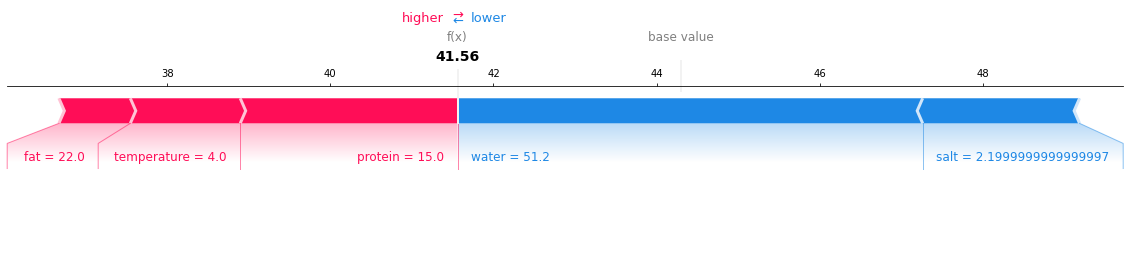

Jambon


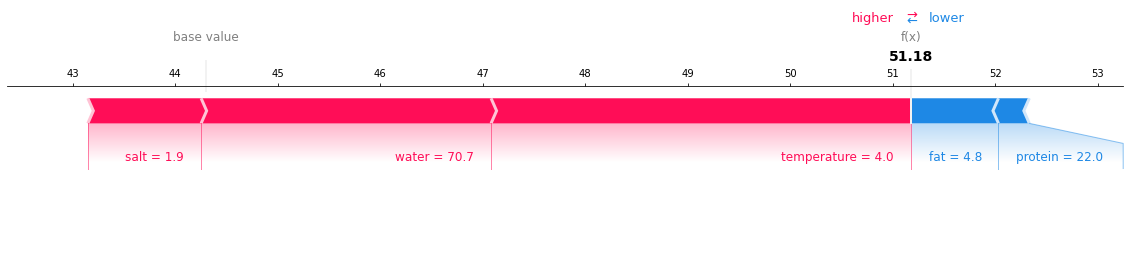

Fromage


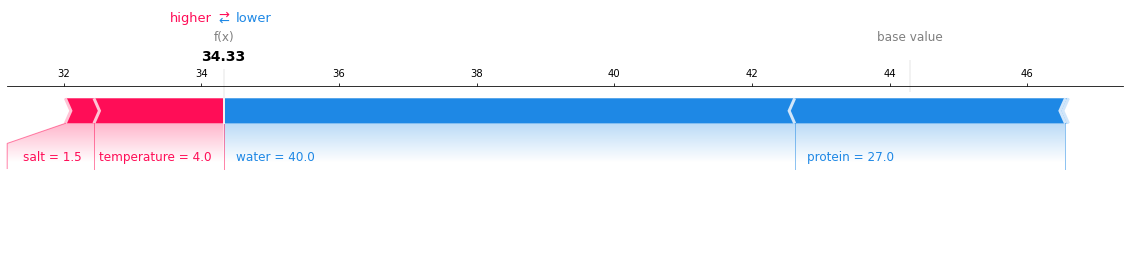

Saumon


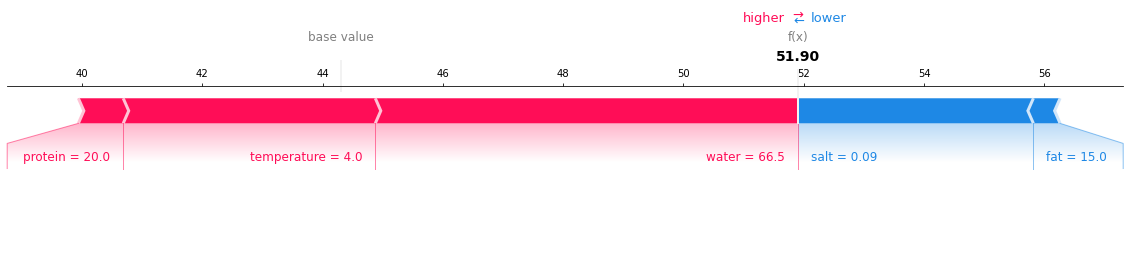

In [10]:
for formulation in to_pred.index:
    print(formulation)
    
    row = to_pred.loc[ formulation, ["temperature", "fat", "protein", "water", "salt"]]
    
    # Shap
    shap_values = ex.shap_values(row)
    shap.force_plot(ex.expected_value,
                    shap_values,
                    row,
                    matplotlib = True,
                    feature_names = ["temperature", "fat", "protein", "water", "salt"])